In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification-part-2/soil_competition-2025/sample_submission.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/465084323936570da664f0ca8dc90326.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/1aa0b12029d35e778dba5bff1255c638.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/6df2c3dcd4fb59298c7a73467ea72eeb.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/107f25ebd87f581ea57c630a2dcdf50c.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/dc35d58782615e4f9582c6b32c8b956e.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/c7af21ff925c51adb526c487148bac6d.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/e8bdb9805d455093ab4f9503cad8052b.jpg
/kaggle/input/soil-class

# Importing Required Libraries

This cell imports libraries for soil classification project:

- **os**: Manages file paths and directories.
- **numpy as np**: Handles numerical operations on arrays.
- **pandas as pd**: Processes datasets like CSV files.
- **matplotlib.pyplot as plt**: Creates visualizations like plots.
- **seaborn as sns**: Enhances visualizations, e.g., bar plots.
- **PIL.Image**: Loads and manipulates images.
- **sklearn.metrics.f1_score, classification_report**: Evaluates model performance.
- **tensorflow.keras.applications.EfficientNetB0**: Provides the EfficientNet-B0 model.
- **tensorflow.keras.applications.efficientnet.preprocess_input**: Preprocesses images for EfficientNet.
- **tensorflow.keras.preprocessing.image**: Loads and preprocesses images.
- **sklearn.metrics.pairwise.cosine_similarity**: Computes vector similarities.
- **sklearn.preprocessing.normalize**: Normalizes data for scaling.
- **tqdm**: Shows progress bars for loops.

This sets up tools for image processing, model building, and evaluation using TensorFlow.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tqdm import tqdm

2025-05-25 08:04:45.261378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748160285.515496      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748160285.593716      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting File Paths and Image Size

- **TRAIN_DIR**: Points to the training images folder (`/kaggle/input/soil-classification-part-2/soil_competition-2025/train`).
- **TEST_DIR**: Points to the test images folder (`/kaggle/input/soil-classification-part-2/soil_competition-2025/test`).
- **LABELS_PATH**: Specifies the path to `train_labels.csv`, containing image IDs and soil type labels.
- **SAMPLE_SUB_PATH**: Specifies the path to `sample_submission.csv`, providing the format for competition submissions.
- **IMG_SIZE**: Defines the target image size (224x224 pixels) for preprocessing.

This organizes file paths and sets a consistent image size for the soil classification project.

In [3]:
TRAIN_DIR = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
TEST_DIR = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'
LABELS_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'
SAMPLE_SUB_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/sample_submission.csv'

IMG_SIZE = (224, 224)

# Loading and Displaying Label Data

- Loads the `train_labels.csv` file from `LABELS_PATH` into a pandas DataFrame (`labels_df`).
- Prints the first few rows of `labels_df` to show the structure of the training data, including image IDs and soil type labels.

This helps verify the content and format of the label data for the soil classification task.

In [4]:
labels_df = pd.read_csv(LABELS_PATH)
print("\n Label Data:")
print(labels_df.head())


 Label Data:
           image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1


# Visualizing Label Distribution

- **Label Counts**: Calculates the number of images per soil type in `labels_df` using the `label` column and prints the counts.
- **Visualization**: Creates a bar plot using `seaborn.countplot` to show the distribution of soil types.
  - Plot size is 6x4 inches.
  - Title: "Label Distribution".
- Displays the plot to visualize how balanced or imbalanced the soil types are in the dataset.

This helps understand the distribution of soil types in the training data.


 Label Distribution:
label
1    1222
Name: count, dtype: int64


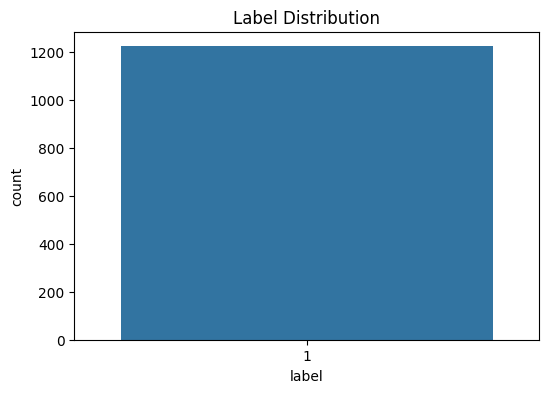

In [5]:
print("\n Label Distribution:")
label_counts = labels_df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(6,4))
sns.countplot(data=labels_df, x='label')
plt.title('Label Distribution')
plt.show()

# Displaying Sample Images

- Defines a `show_sample_images` function to display `n` images (default 3) from a specified directory:
  - Takes `dir_path` (image directory), `label_df` (optional DataFrame with image IDs), and `n` (number of images).
  - Creates a 1x3 subplot grid (15x5 inches).
  - Randomly selects `n` images from `label_df` (if provided) or takes the first `n` files from `dir_path`.
  - Loads each image using `PIL.Image`, displays it in a subplot, and sets the title to the image ID.
  - Hides axes for a cleaner view and adjusts layout.

- **Training Images**:
  - Calls `show_sample_images` with `TRAIN_DIR` and `labels_df` to show 3 random training images with their IDs.

- **Test Images**:
  - Lists image IDs from `TEST_DIR` using `os.listdir`.
  - Creates a temporary DataFrame with test image IDs.
  - Calls `show_sample_images` to display 3 test images with their IDs.

This visualizes sample images from the training and test sets to inspect their appearance.


 Sample Training Images:


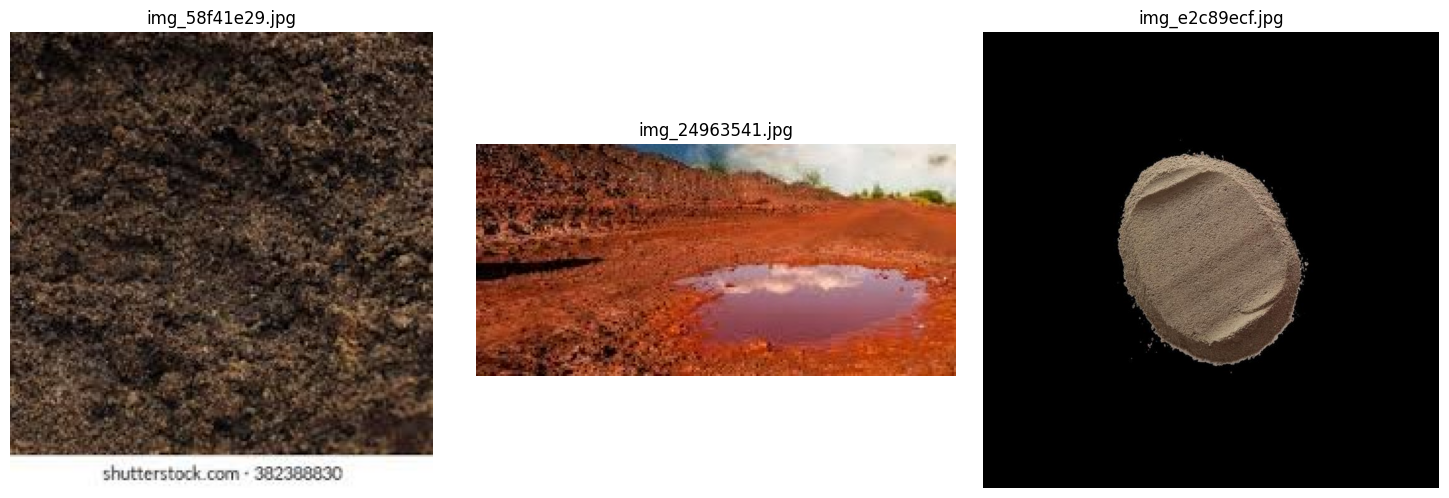


 Sample Test Images:


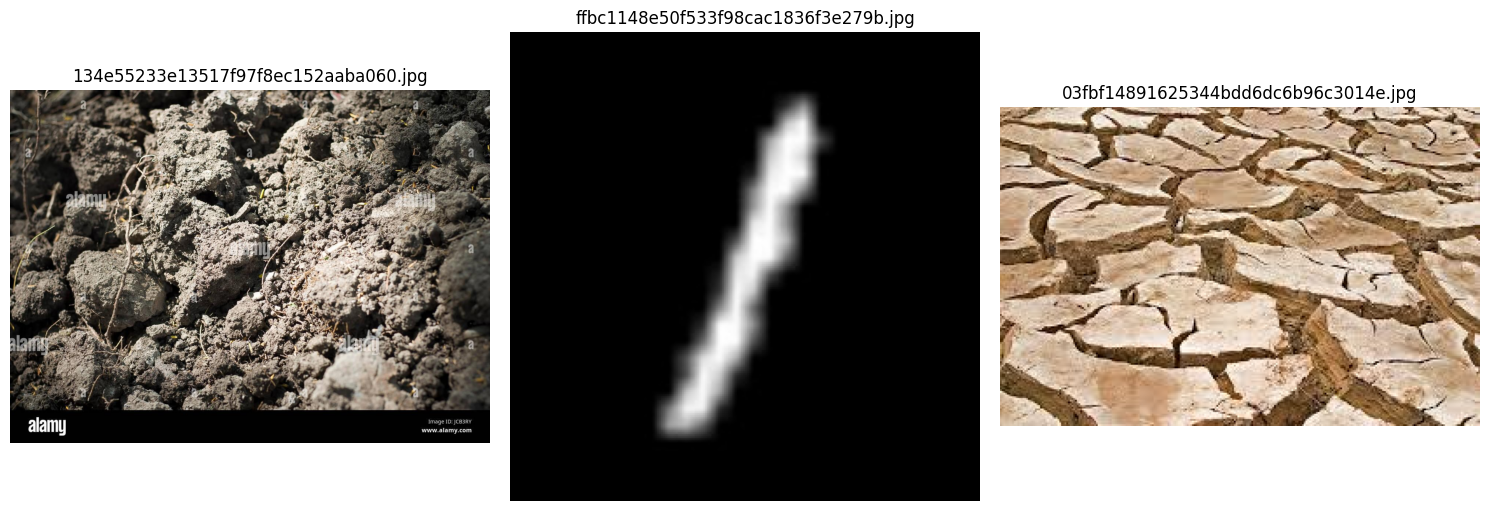

In [6]:
def show_sample_images(dir_path, label_df=None, n=3):
    fig, axes = plt.subplots(1, n, figsize=(15,5))
    selected = label_df.sample(n) if label_df is not None else pd.DataFrame({'image_id': os.listdir(dir_path)[:n]})
    for i, img_id in enumerate(selected['image_id']):
        img = Image.open(os.path.join(dir_path, img_id))
        axes[i].imshow(img)
        axes[i].set_title(f"{img_id}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("\n Sample Training Images:")
show_sample_images(TRAIN_DIR, labels_df)

print("\n Sample Test Images:")
test_ids = os.listdir(TEST_DIR)
show_sample_images(TEST_DIR, pd.DataFrame({'image_id': test_ids}))

# Initializing Feature Extraction Model

- **Base Model**: Loads a pre-trained EfficientNet-B0 model from `tensorflow.keras.applications` with ImageNet weights, excluding the top classification layer and using global average pooling to output feature vectors.
- **Feature Extraction Function**:
  - Defines `extract_features` to extract features from an image:
    - Loads an image from `img_path` and resizes it to `IMG_SIZE` (224x224).
    - Converts the image to a NumPy array and adds a batch dimension.
    - Applies `preprocess_input` to normalize the image for EfficientNet.
    - Uses the model to predict features, returning a flattened feature vector.

This sets up feature extraction for images using a pre-trained EfficientNet-B0 model.

In [7]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

2025-05-25 08:05:02.942189: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Extracting Features from Training Images

- Iterates through all images in `TRAIN_DIR` using `os.listdir` with a progress bar (`tqdm`).
- For each image:
  - Constructs the full image path.
  - Extracts features using the `extract_features` function with the pre-trained EfficientNet-B0 model.
  - Stores the feature vector in `train_features` and the image ID in `train_ids`.
- Normalizes the feature vectors in `train_features` using `sklearn.preprocessing.normalize` for consistent scaling.

This generates normalized feature vectors for all training images, preparing them for further analysis or classification.

In [8]:
print("\n Extracting training features...")
train_features = []
train_ids = []
for img_name in tqdm(os.listdir(TRAIN_DIR)):
    img_path = os.path.join(TRAIN_DIR, img_name)
    feat = extract_features(img_path, base_model)
    train_features.append(feat)
    train_ids.append(img_name)
train_features = normalize(np.array(train_features))



 Extracting training features...


100%|██████████| 1222/1222 [03:08<00:00,  6.50it/s]


# Extracting Features from Test Images

- Iterates through test image IDs in `test_ids` with a progress bar (`tqdm`).
- For each image:
  - Constructs the full image path in `TEST_DIR`.
  - Extracts features using the `extract_features` function with the pre-trained EfficientNet-B0 model.
  - Stores the feature vector in `test_features`.
- Normalizes the feature vectors in `test_features` using `sklearn.preprocessing.normalize` for consistent scaling.

This generates normalized feature vectors for all test images, preparing them for classification or similarity analysis.

In [9]:
print("\n Extracting test features...")
test_features = []
for img_name in tqdm(test_ids):
    img_path = os.path.join(TEST_DIR, img_name)
    feat = extract_features(img_path, base_model)
    test_features.append(feat)
test_features = normalize(np.array(test_features))


 Extracting test features...


100%|██████████| 967/967 [02:22<00:00,  6.80it/s]


# Computing Cosine Similarity

- Calculates cosine similarity between `test_features` and `train_features` using `sklearn.metrics.pairwise.cosine_similarity`.
- For each test image, finds the maximum similarity score (`max_sims`) across all training images.

This measures how similar each test image’s features are to the training images, likely for classification or matching purposes.

In [10]:
cos_sims = cosine_similarity(test_features, train_features)
max_sims = cos_sims.max(axis=1)

# Applying Similarity Threshold

- Defines a threshold value of 0.8 for classifying test images based on cosine similarity.
- Prints the threshold value for reference.
- Creates `test_preds` by checking if the maximum similarity scores (`max_sims`) exceed the threshold (0.8).
  - Assigns 1 to test images with similarity above the threshold and 0 otherwise, converting to integers.

This classifies test images based on their similarity to training images, likely identifying matches or outliers.

In [11]:
THRESHOLD = 0.8
print(f"\n Using threshold = {THRESHOLD}")
test_preds = (max_sims > THRESHOLD).astype(int)


 Using threshold = 0.8


# Evaluating Nearest Neighbor on Training Set

- Creates a dictionary `img2label` mapping image IDs to their labels from `labels_df`.
- **Cosine Similarity**:
  - Computes cosine similarity between `train_features` (training image features) using `cosine_similarity`.
  - Sets the diagonal to -1 to ignore self-similarity (an image matching itself).
- **Nearest Neighbor Prediction**:
  - Finds the index of the most similar training image for each training image using `argmax`.
  - Maps these indices to predicted labels (`y_pred_train`) and true labels (`y_true_train`) using `img2label`.
- **Classification Report**:
  - Prints a classification report for the training set, showing precision, recall, and F1-score for each soil type.
- **Minimum F1-Score**:
  - Computes per-class F1-scores and prints the minimum as the competition metric.
- **Confusion Matrix**:
  - Generates a confusion matrix for the training set predictions.
  - Plots a heatmap (6x5 inches) with `seaborn`, annotated with counts, using soil type labels from `label_counts.index`.
  - Labels axes as "Predicted Labels" and "True Labels", with the title "Confusion Matrix (Training Set)".

This performs a sanity check by evaluating nearest neighbor classification on the training set using cosine similarity.


 Evaluating on training set (sanity check using nearest neighbor)...

 Classification Report (on training data):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1222

    accuracy                           1.00      1222
   macro avg       1.00      1.00      1.00      1222
weighted avg       1.00      1.00      1.00      1222


 Minimum F1-score (Competition Metric): 1.0000


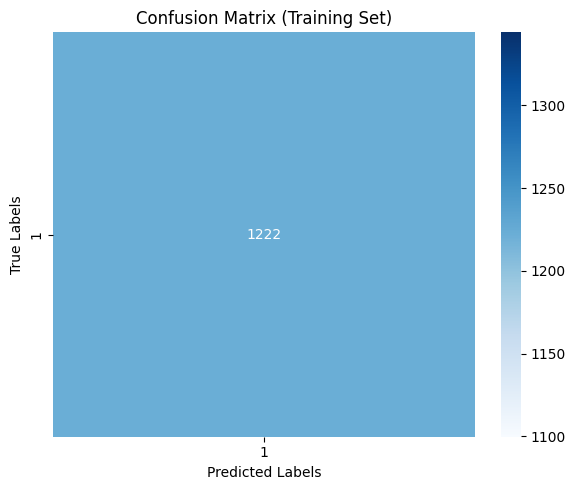

In [12]:
img2label = dict(zip(labels_df['image_id'], labels_df['label']))

print("\n Evaluating on training set (sanity check using nearest neighbor)...")
cos_sims_train = cosine_similarity(train_features, train_features)
np.fill_diagonal(cos_sims_train, -1)  # Ignore self-similarity

top1_indices_train = np.argmax(cos_sims_train, axis=1)
y_pred_train = [str(img2label[train_ids[idx]]) for idx in top1_indices_train]
y_true_train = [str(img2label[img_id]) for img_id in train_ids]

print("\n Classification Report (on training data):")
print(classification_report(y_true_train, y_pred_train, target_names=[str(c) for c in label_counts.index.tolist()]))

f1s = f1_score(y_true_train, y_pred_train, average=None)
print(f"\n Minimum F1-score (Competition Metric): {f1s.min():.4f}")

cm = confusion_matrix(y_true_train, y_pred_train, labels=[str(c) for c in label_counts.index])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(c) for c in label_counts.index], yticklabels=[str(c) for c in label_counts.index])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Training Set)")
plt.tight_layout()
plt.show()

# Creating and Saving Submission File

- Creates a pandas DataFrame `submission_df` with:
  - `image_id`: Test image IDs from `test_ids`.
  - `label`: Predicted labels (`test_preds`) based on cosine similarity threshold.
- Saves the DataFrame to `submission.csv` without an index column.
- Prints a confirmation message that the submission file has been saved.

This prepares the final predictions for submission to the Kaggle competition.

In [13]:
submission_df = pd.DataFrame({
    'image_id': test_ids,
    'label': test_preds
})
submission_df.to_csv('submission.csv', index=False)
print("\n Submission saved as submission.csv")


 Submission saved as submission.csv
